# Limpieza y Tratamiento de Datos
### Teniendo en cuenta el proyecto de clasificación docente usando aprendizaje automático, se procede a realizar un plan ETL (Extracción, Transformación y Carga). Sin embargo, antes de ello es necesario hacer un análisis de completitud y duplicación, es decir, requiero saber cuántos valores faltantes existen por columna, como así tambien qué porcentaje de valores faltan.

In [40]:
# Importo las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargo el dataset dataset_jcyd_ok.
dat_excel  = pd.read_excel('C:/Users/Usuario/OneDrive/Documentos/BASE_DE_DATOS_E_INTELIGENCIA_ARTIFICIAL/2025/APRENDIZAJE AUTOMATICO (2A1C)/PARCIAL/Clasificacion_Asignacion_DocentesTDF/data/raw/dataset_jcyd_ok.xlsx') 
dat_excel.head()

,idespacio,idtitulo,idtitulo_real,idcasaestudio,caracter,idNivel_espacio,desc_espacio,tipo_espacio,ciudad_espacio,resolucion_espacio,titulo,resolucion,nombre,facultad,provincia,ciudad
0,611,0046200276,462,00276,D,1.0,A.T.T.P. Inglés,Cargo,101.0,1354/17,PROFESORA DE INGLÉS,757-ME-09,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,LIBERTADOR GENERAL SAN MARTIN
1,708,0046200276,462,00276,D,2.0,Lengua Extranjera: Inglés,Espacio,111.0,1354/17,PROFESORA DE INGLÉS,757-ME-09,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,LIBERTADOR GENERAL SAN MARTIN
2,808,0046200276,462,00276,D,3.0,Lengua Extranjera: Inglés,Espacio,111.0,1354/17,PROFESORA DE INGLÉS,757-ME-09,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,LIBERTADOR GENERAL SAN MARTIN
3,2012,0046200276,462,00276,D,4.0,Lenguas Extranjeras: Inglés,Espacio,111.0,1354/17,PROFESORA DE INGLÉS,757-ME-09,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,LIBERTADOR GENERAL SAN MARTIN
4,2046,0046200276,462,00276,D,5.0,Estudios Interculturales en Lengua I y II (Ing...,Espacio,111.0,1354/17,PROFESORA DE INGLÉS,757-ME-09,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,LIBERTADOR GENERAL SAN MARTIN


## I-Análisis de valores faltantes
### Se busca encontrar que columnas tienen valores nulos y su porcentajes: 

In [41]:
# 1. Cuento los valores nulos por columna
faltantes = dat_excel.isnull().sum()

In [42]:
# 2. Calculo el porcentaje de valores nulos
porcentaje_faltantes = (faltantes / len(dat_excel)) * 100

In [43]:
# 3. Combino en un único DataFrame ordenado
faltantes_dat_excel = pd.DataFrame({
    'Nulos': faltantes,
    '% Nulos': porcentaje_faltantes
}).sort_values(by='% Nulos', ascending=False)

In [44]:
# 4. Veriico si se puede completar columnas clave agrupando por ID
completables_por_id = {}
for col in ['titulo', 'nombre', 'provincia']:
    completables_por_id[col] = (
        dat_excel.groupby('idtitulo_real')[col].apply(lambda x: x.isnull().sum())
        .sum()
    )

In [45]:
faltantes_dat_excel, completables_por_id

(                    Nulos    % Nulos
 facultad            38811  73.316835
 ciudad              10894  20.579568
 provincia            2569   4.853030
 resolucion           2125   4.014281
 nombre                241   0.455267
 titulo                125   0.236134
 idNivel_espacio         1   0.001889
 desc_espacio            1   0.001889
 tipo_espacio            1   0.001889
 ciudad_espacio          1   0.001889
 resolucion_espacio      1   0.001889
 idespacio               0   0.000000
 idtitulo                0   0.000000
 idtitulo_real           0   0.000000
 idcasaestudio           0   0.000000
 caracter                0   0.000000,
 {'titulo': 125, 'nombre': 241, 'provincia': 2569})

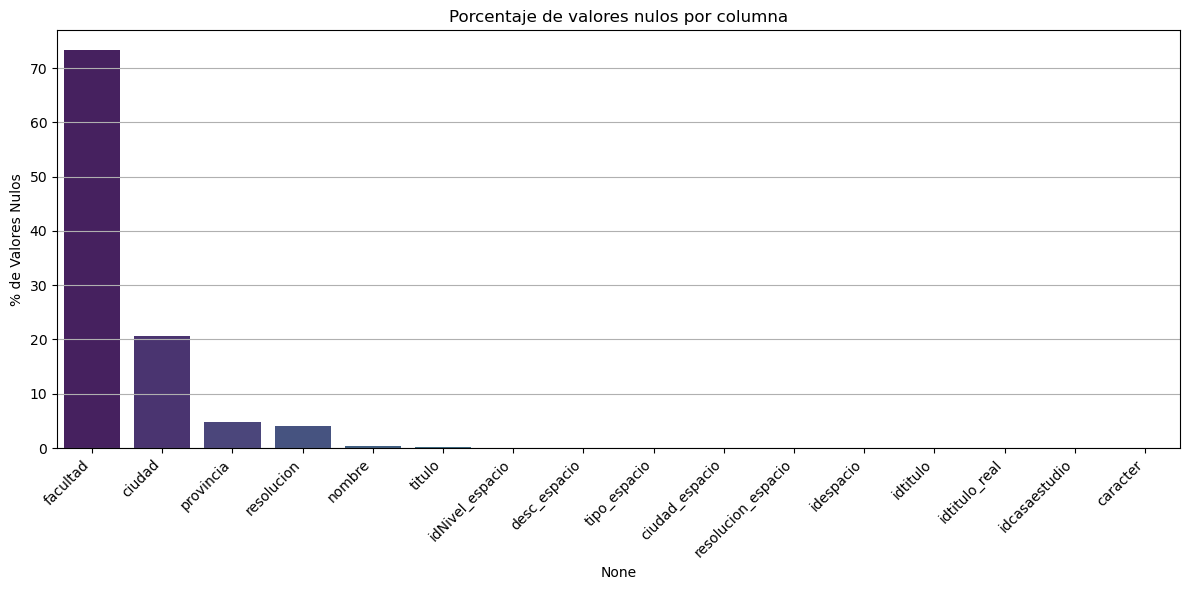

In [46]:
# Grafico la informacion obtenida
plt.figure(figsize=(12, 6))
sns.barplot(x=faltantes_dat_excel.index, y=faltantes_dat_excel['% Nulos'], palette="viridis", hue=faltantes_dat_excel.index, legend=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel('% de Valores Nulos')
plt.title('Porcentaje de valores nulos por columna')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Análisis de valores faltantes: se puede observar que:
#### - facultad: 73% de valores nulos. Estos datos probablemente no sean útil.

#### - titulo, nombre, provincia: algunos nulos. Se pueden completar si hay duplicados con mismos idtitulo_real o idcasaestudio.

#### - resolucion: útil solo si aporta información diferenciadora, si no, se puede descartar.

## II- PASOS DEL ETL
### Según el objetivo de mi proyecto, debo concentrarme en las columnas de titulo, nombre (de la institución emisora),facultad, provincia (de la institución), desc_espacio (espacio curricular) y el caracter (es la variable objetivo: Docente, Habilitante, Supletorio). Por tal motivo el ETL se enfocará sobre los valores faltantes. 


### 1º) FILTRADO DE VARIABLES RELEVANTES
#### Creo una lista con los nombres de las variables que voy a utilizar. Posteriormente  selecciona esas columnas del DataFrame "dat_excel" y las copia en uno nuevo llamado "df_modelo", con el cual estaré trabajando en este proyecto.

In [47]:
variables_modelo = [
    "idtitulo_real", "titulo", "nombre", "facultad",
    "provincia", "desc_espacio", "caracter"
]
df_modelo = dat_excel[variables_modelo].copy()
df_modelo.head()

,idtitulo_real,titulo,nombre,facultad,provincia,desc_espacio,caracter
0,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,A.T.T.P. Inglés,D
1,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,Lengua Extranjera: Inglés,D
2,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,Lengua Extranjera: Inglés,D
3,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,Lenguas Extranjeras: Inglés,D
4,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,NaN,JUJUY,Estudios Interculturales en Lengua I y II (Ing...,D


### 2º) LIMPIEZA DE VALORES NULOS
#### Se quiere realizar la limpieza y preparación de datos en df_modelo, inicialmente,  evitar advertencias futuras, se configura pandas, luego se busca eliminar filas con valores faltantes en variables clave, rellenar datos nulos en 'titulo', 'nombre' y 'provincia' usando agrupamientos por 'idtitulo_real', se elimina la columna 'facultad' debido a su alto porcentaje de valores nulos, y por ultimo se eliminando cualquier fila restante con datos incompletos para dejar un conjunto de datos limpio y apto para hacer la aplicacion de modelos.

In [48]:

# Eliminar filas sin 'caracter' o 'desc_espacio' (variables esenciales)
df_modelo.dropna(subset=["caracter", "desc_espacio"], inplace=True)



In [49]:
# Rellenar campos nulos de título, nombre, provincia usando idtitulo_real
df_modelo[['titulo', 'nombre', 'provincia']] = (
    df_modelo.groupby('idtitulo_real')[['titulo', 'nombre', 'provincia']]
    .transform(lambda x: x.ffill().bfill())
)



C:\Users\Usuario\AppData\Local\Temp\ipykernel_10472\3910867024.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.ffill().bfill())


In [50]:
# Facultades: como el 73% es nulo, y difícil de recuperar, se decide que se debe eliminar
df_modelo.drop(columns=["facultad"], inplace=True)

df_modelo.head()

,idtitulo_real,titulo,nombre,provincia,desc_espacio,caracter
0,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,A.T.T.P. Inglés,D
1,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,Lengua Extranjera: Inglés,D
2,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,Lengua Extranjera: Inglés,D
3,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,Lenguas Extranjeras: Inglés,D
4,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,Estudios Interculturales en Lengua I y II (Ing...,D


In [51]:
# Si aún quedan nulos, eliminarlos para modelo base
df_modelo.dropna(inplace=True)



### 3º) TRANSFORMACION
#### En este proceso, busco convertir a mayúsculas y eliminar espacios en blanco en las columnas de Título, Nombre, Provincia y Desc_espacio para estandarizar los datos. Además, se quiere reemplazar las abreviaturas en 'caracter' por sus nombres completos para facilitar el análisis.

In [52]:
# Normalizar texto (lower, sin tildes, etc.)
df_modelo['titulo'] = df_modelo['titulo'].str.upper().str.strip()
df_modelo['nombre'] = df_modelo['nombre'].str.upper().str.strip()
df_modelo['provincia'] = df_modelo['provincia'].str.upper().str.strip()
df_modelo['desc_espacio'] = df_modelo['desc_espacio'].str.upper().str.strip()

In [53]:
# Codificar la variable objetivo
df_modelo['caracter'] = df_modelo['caracter'].map({'D': 'Docente', 'H': 'Habilitante', 'S': 'Supletorio'})
df_modelo.head()

,idtitulo_real,titulo,nombre,provincia,desc_espacio,caracter
0,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,A.T.T.P. INGLÉS,Docente
1,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUA EXTRANJERA: INGLÉS,Docente
2,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUA EXTRANJERA: INGLÉS,Docente
3,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUAS EXTRANJERAS: INGLÉS,Docente
4,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,ESTUDIOS INTERCULTURALES EN LENGUA I Y II (ING...,Docente


### 4º) EXPORTAR
#### Se requiere guardar el conjunto de datos limpio en un archivo CSV en una ruta especifi para que pueda ser utilizado en el entrenamiento de modelo.

In [54]:
# Guardo el dataset limpio para poder usar el modelo
df_modelo.to_csv("C:/Users/Usuario/OneDrive/Documentos/BASE_DE_DATOS_E_INTELIGENCIA_ARTIFICIAL/2025/APRENDIZAJE AUTOMATICO (2A1C)/PARCIAL/Clasificacion_Asignacion_DocentesTDF/data/processed/dataset_docentes_etl.csv", index=False)
df_modelo.head()

,idtitulo_real,titulo,nombre,provincia,desc_espacio,caracter
0,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,A.T.T.P. INGLÉS,Docente
1,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUA EXTRANJERA: INGLÉS,Docente
2,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUA EXTRANJERA: INGLÉS,Docente
3,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,LENGUAS EXTRANJERAS: INGLÉS,Docente
4,462,PROFESORA DE INGLÉS,INSTITUTO DE EDUCACIÓN SUPERIOR N° 10,JUJUY,ESTUDIOS INTERCULTURALES EN LENGUA I Y II (ING...,Docente
